In [1]:
import pandas as pd
import numpy as np
import gradio as gr
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score, TimeSeriesSplit, learning_curve
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, RationalQuadratic, Matern, ExpSineSquared
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [2]:
df = pd.read_csv('compiled_dataset.csv', index_col=0, parse_dates=True)
df = df.loc['2010-11-18':'2020-09-18']

In [3]:
# SPLIT TRAIN-TEST
train_size = int(0.9 * len(df))
df_train = df.iloc[:train_size]
df_test = df.iloc[train_size:]

X_train = df_train.drop(columns=['cushing_crude_oil_price'])
y_train = df_train['cushing_crude_oil_price']
X_test = df_test.drop(columns=['cushing_crude_oil_price'])
y_test = df_test['cushing_crude_oil_price']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [4]:
# SET UP MODELS
models = {
    'Linear Regression': LinearRegression(),
    'SVM Linear': SVR(kernel='linear'),
    'SVM Quadratic': SVR(kernel='poly', degree=2),
    'SVM Cubic': SVR(kernel='poly', degree=3),
    'SVM Gaussian Fine': SVR(kernel='rbf', gamma='scale'),
    'SVM Gaussian Medium': SVR(kernel='rbf', gamma='auto'),
    'SVM Gaussian Coarse': SVR(kernel='rbf', gamma=0.1),
    'Fine Tree': DecisionTreeRegressor(max_depth=5),
    'Medium Tree': DecisionTreeRegressor(max_depth=10),
    'Coarse Tree': DecisionTreeRegressor(max_depth=15),
    'Bagged Trees': BaggingRegressor(),
    'Boosted Trees': GradientBoostingRegressor()
}

In [5]:
rmse_score = lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred))
rmse_scorer = make_scorer(rmse_score, greater_is_better=False)

results_list = []

# TRAINING & EVALUATION
for name, model in models.items():
    try:
        scores = cross_val_score(model, X_train_scaled, y_train, cv=TimeSeriesSplit(n_splits=5), scoring=rmse_scorer)
        in_sample_rmse = -scores.mean()
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        out_sample_rmse = rmse_score(y_test, y_pred)
        results = {
            'Model': name,
            'In-Sample RMSE': in_sample_rmse,
            'OOS RMSE': out_sample_rmse
        }
    except Exception as e:
        results = {
            'Model': name,
            'In-Sample RMSE': str(e),
            'OOS RMSE': 'Error'
        }
    results_list.append(results)

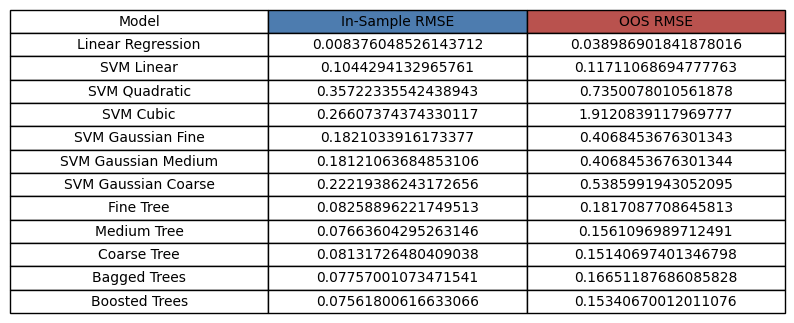

In [6]:
# PRINTING NICE TABLE
results_df = pd.DataFrame(results_list)
results_df = results_df.apply(lambda x: round(x, 4) if isinstance(x, (float, int)) else x)
fig, ax = plt.subplots(figsize=(10, 2))
ax.axis('tight')
ax.axis('off')
the_table = ax.table(cellText=results_df.values, colLabels=results_df.columns, loc='center',
                     cellLoc='center', colColours=['none', '#4d7caf', '#b9524e'])
the_table.auto_set_font_size(False)
the_table.set_fontsize(10)
the_table.scale(1, 1.4)
plt.show()

In [8]:
def update_model(model_name):
    # Get the selected model
    model = models[model_name]
        
    # Calculate metrics
    cv = TimeSeriesSplit(n_splits=5)
    scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring=rmse_scorer)
    in_sample_rmse = -scores.mean()
        
    #Fit the model
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    out_sample_rmse = rmse_score(y_test, y_pred)
        
    # Create plot data
    plot_df = pd.DataFrame({
        'date': y_test.index,
        'Actual': y_test,
        'Predicted': y_pred
    })
    print(plot_df)     
    plot_data = pd.melt(plot_df, id_vars=['date'], 
                value_vars=['Actual', 'Predicted'],
                var_name='variable', value_name='value')
    return (
        f"{in_sample_rmse:.4f}",
        f"{out_sample_rmse:.4f}",
        gr.LinePlot(
            value=plot_data,
            x='date',
            y='value',
            color='variable',
            title=f'Test results: {model_name}',
            overlay_point=True,
            tooltip=['date', 'variable', 'value'],
            height=400
        ),
    )

with gr.Blocks() as demo:
    with gr.Row():
        with gr.Column():
            model_dropdown = gr.Dropdown(
                choices=list(models.keys()),
                value=list(models.keys())[0],
                label="Model Selection",
                interactive=True
            )
            run_button = gr.Button("Run Model", variant="primary")
            in_sample_text = gr.Textbox(label="Training RMSE")
            out_sample_text = gr.Textbox(label="Test RMSE")
        
        plot = gr.LinePlot(interactive=True)

    run_button.click(
        update_model,
        inputs=model_dropdown,
        outputs=[in_sample_text, out_sample_text, plot]
    )

demo.launch()

* Running on local URL:  http://127.0.0.1:7870
* To create a public link, set `share=True` in `launch()`.


                 date    Actual  Predicted
date                                      
2019-09-26 2019-09-26  4.029628   4.032050
2019-09-27 2019-09-27  4.024458   4.021652
2019-09-30 2019-09-30  3.990649   3.988880
2019-10-01 2019-10-01  3.981549   3.980382
2019-10-02 2019-10-02  3.964046   3.962243
...               ...       ...        ...
2020-09-14 2020-09-14  3.617115   3.618650
2020-09-15 2020-09-15  3.645189   3.644900
2020-09-16 2020-09-16  3.693120   3.691252
2020-09-17 2020-09-17  3.713328   3.710453
2020-09-18 2020-09-18  3.715765   3.715711

[257 rows x 3 columns]
